# Speech Emotion Recognition

In [ ]:
#%pip install playsound
#%pip install tensorflow --user
#%pip install librosa
#%pip install torch --user
#%pip install optuna --user

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave
import librosa
import os
from IPython.display import Audio
import IPython.display as ipd
from playsound import playsound
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import soundfile as sf
from sklearn.preprocessing import StandardScaler

stringLabels = ["SAD", "ANG", "NEU", "HAP", "FEA", "DIS"]
labelToIndex = {stringLabels[i]: i for i in range(len(stringLabels))}

## Loading the dataset

- We will load the CREMA dataset, then we will pad the audio files to have the same length. Then we can rewrite the audio files to the disk which can be preprocessed by the `librosa` library later on.

In [2]:
files = np.array([])
labels = np.array([])
maxLen = 110361
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        # Reading the wav file
        if filename.endswith('.wav'):
            # Read the wav file (mono)
            files = np.append(files, os.path.join(dirname, filename))
            labels = np.append(labels, filename.split("_")[2])

In [3]:
# Now let's get the maximum length of the audio files
maxLen = 0
for file in files:
    audio, sr = librosa.load(file)
    if len(audio) > maxLen:
        maxLen = len(audio)

# Let's pad all the audio files with zeros so that they all have the same length
for i, file in enumerate(files):
    audio, sr = librosa.load(file)
    paddedAudio = np.pad(audio, (0, maxLen - len(audio)), mode='constant')
    sf.write(file, paddedAudio, sr)

# Check if all the files have the same length
for file in files:
    audio, sr = librosa.load(file)
    if len(audio) != maxLen:
        print("Error")

print("The maximum length of the audio files is: " + str(maxLen))

The maximum length of the audio files is: 110361


## Audio Processing

In [3]:
def playAudio(path):
    playsound(path)

def getSamplingFrequency(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    return frameRate

def getAudioSignal(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    # Find the time of the audio file
    time = np.linspace(0, len(signal) / frameRate, num=len(signal))
    return signal, time


def calculateZeroCrossingRate(audioPath, frameSize, hopSize):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.zero_crossing_rate( y= audio, frame_length= frameSize, hop_length= hopSize)[0]) # We can make center=True to get more accurate results

def calculateEnergy(audioPath, frameSize, hopSize):
    """
    audioPath: The path of the audio file
    frameSize: The number of samples in each frame
    hopSize: The number of samples between successive frames
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.rms(y = audio, frame_length= frameSize, hop_length= hopSize)[0] ** 2) # We can make center=True to get more accurate results

def calculateMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    """"
    n_fft: The number of points in the FFT, which determines the frequency resolution of the spectrogram
    hopSize: The number of samples between successive frames
    n_mels: The number of mel frequency bands to generate in the spectrogram or the number of filters in the filterbank
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    # Normalize between 0 and 1
    if mel_spec_db.max() - mel_spec_db.min() != 0:
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / ((mel_spec_db.max() - mel_spec_db.min()) + 1e-6) # eps for numerical stability
    else:
        mel_spec_db = mel_spec_db - mel_spec_db.min()
    return mel_spec_db

def addNoise(y, sr):
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    return y_noise

def changeSpeed(y, sr):
    speed_change = np.random.uniform(low=0.9, high=1.1)
    return librosa.effects.time_stretch(y, rate = speed_change)

def timeShift(y, sr):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 1000)
    return np.roll(y, shift_range)

def pitchShift(y, sr):
    pitch_change = int(np.random.randint(low=-3, high = 3))
    return librosa.effects.pitch_shift(y, sr = sr, n_steps=pitch_change)

def volumeScale(y, sr):
    volume_change = np.random.uniform(low=0.5, high = 1.5)
    return y * volume_change

def augmentData(data, label, savePath, noise, time_shift, change_speed, pitch_shift, volume_scale):
    augmentedData = []
    augmentedLabel = []
    flag = 0
    if not os.path.exists(savePath):
        os.makedirs(savePath)
        flag = 1
        
    for i in range(len(data)):
        fileName = data[i][8:23]
        
        if not flag:
            # Appending all of them to the augmentedData
            augmentedData.append(data[i])
            augmentedLabel.append(label[i])
            if noise:
                augmentedData.append(savePath+ "/" + str(fileName)+"_noised.wav")
                augmentedLabel.append(label[i])
            if change_speed:
                augmentedData.append(savePath+ "/" + str(fileName)+"_changeSpeed.wav")
                augmentedLabel.append(label[i])
            if time_shift:
                augmentedData.append(savePath+ "/" + str(fileName)+"_timeShift.wav")
                augmentedLabel.append(label[i])
            if pitch_shift:
                augmentedData.append(savePath+ "/" + str(fileName)+"_pitchShift.wav")
                augmentedLabel.append(label[i])
            if volume_scale:
                augmentedData.append(savePath+ "/" + str(fileName)+"_volumeScale.wav")
                augmentedLabel.append(label[i])
            continue
        
        augmentedData.append(data[i])
        augmentedLabel.append(label[i])

        audio, sr = librosa.load(data[i], sr=None)
        if noise:
            noisedAudio = addNoise(audio, sr)
            if( maxLen > len(noisedAudio) ):
                noisedAudio = np.pad(noisedAudio, (0, maxLen - len(noisedAudio)), 'constant')
            noisedAudio = noisedAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_noised.wav", noisedAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_noised.wav")
            augmentedLabel.append(label[i])
        if change_speed:
            changeSpeedAudio = changeSpeed(audio, sr)
            if( maxLen > len(changeSpeedAudio) ):
                changeSpeedAudio = np.pad(changeSpeedAudio, (0, maxLen - len(changeSpeedAudio)), 'constant')
            changeSpeedAudio = changeSpeedAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_changeSpeed.wav", changeSpeedAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_changeSpeed.wav")
            augmentedLabel.append(label[i])
        if time_shift:
            timeShiftAudio = timeShift(audio, sr)
            if( maxLen > len(timeShiftAudio) ):
                timeShiftAudio = np.pad(timeShiftAudio, (0, maxLen - len(timeShiftAudio)), 'constant')
            timeShiftAudio = timeShiftAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_timeShift.wav", timeShiftAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_timeShift.wav")
            augmentedLabel.append(label[i])
        if pitch_shift:
            pitchShiftAudio = pitchShift(audio, sr)
            if( maxLen > len(pitchShiftAudio) ):
                pitchShiftAudio = np.pad(pitchShiftAudio, (0, maxLen - len(pitchShiftAudio)), 'constant')
            pitchShiftAudio = pitchShiftAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_pitchShift.wav", pitchShiftAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_pitchShift.wav")
            augmentedLabel.append(label[i])
        if volume_scale:
            volumeScaleAudio = volumeScale(audio, sr)
            if( maxLen > len(volumeScaleAudio) ):
                volumeScaleAudio = np.pad(volumeScaleAudio, (0, maxLen - len(volumeScaleAudio)), 'constant')
            volumeScaleAudio = volumeScaleAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_volumeScale.wav", volumeScaleAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_volumeScale.wav")
            augmentedLabel.append(label[i])
    return augmentedData, augmentedLabel

def plotMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hopSize, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel spectrogram')
    plt.show()

def plotSpectrogram(audioPath, time):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    plt.figure(figsize=(15, 5))
    plt.specgram(audio, Fs=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.show()
    
def plotSignal(signal, time):
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Signal')
    plt.show()

def plotHistogram(data, dataTitle):
    plt.figure(figsize=(15, 5))
    plt.hist(data, bins=15)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Histogram of the ' + dataTitle)
    plt.show()

## Parameters for Audio Features Extraction

- When selecting the window size and hop size for audio classification tasks using a convolutional neural network (CNN), it's important to consider several factors, including the length of the audio samples, the nature of the audio signal, and the computational resources available. Here are some general guidelines we will follow:
  - **Window Size**: The window size determines the amount of audio data that is processed at a time. A larger window size captures more information about the audio signal, but also requires more computational resources. For speech signals, a window size of around 20-30 ms (320-480 samples for 16 kHz audio) is often used, as it captures enough information about individual phonemes while still allowing for some temporal resolution.
  - **Hop Size**: The hop size determines the amount of overlap between adjacent windows. A smaller hop size provides more temporal resolution but requires more computational resources, while a larger hop size provides better computational efficiency but can miss short-term changes in the audio signal. A common hop size is half the window size, i.e. 10-15 ms (160-240 samples for 16 kHz audio).

- size (in samples) = duration (in seconds) x fs


In [48]:
N_MELS = 40 
N_FFT = 512 # 480
HOP_SIZE = 160
SR = getSamplingFrequency(files[0]) # Sampling rate is equal for all files (16kHz)

## Reading, Plotting and Playing the Audio

In [49]:
# display the first audio file
ipd.display(Audio(files[0]))

#### Wave Form

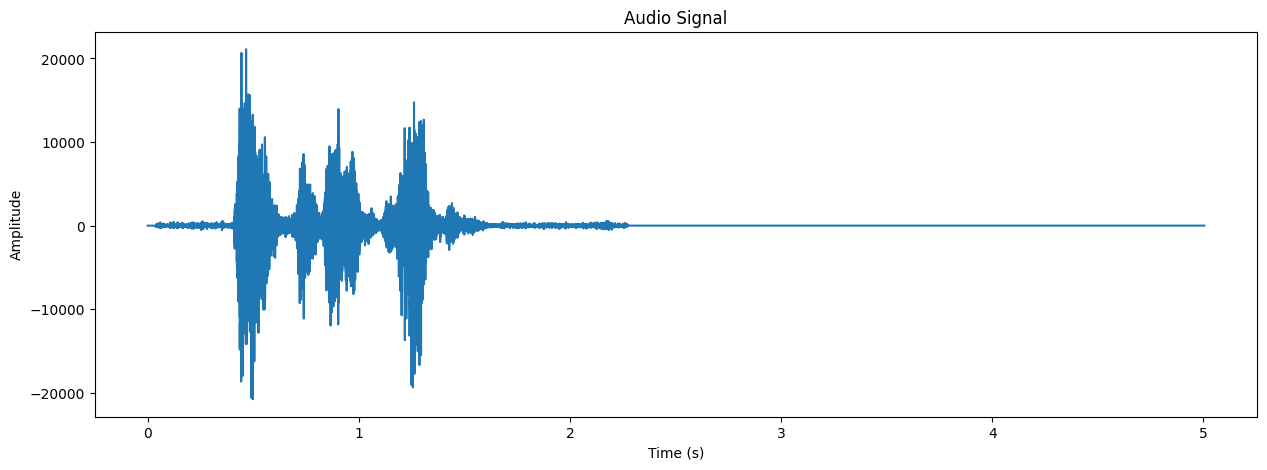

In [50]:
audioSignal, audioTime = getAudioSignal(files[0])
plotSignal(audioSignal, audioTime)

#### Audio Spectrogram

C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


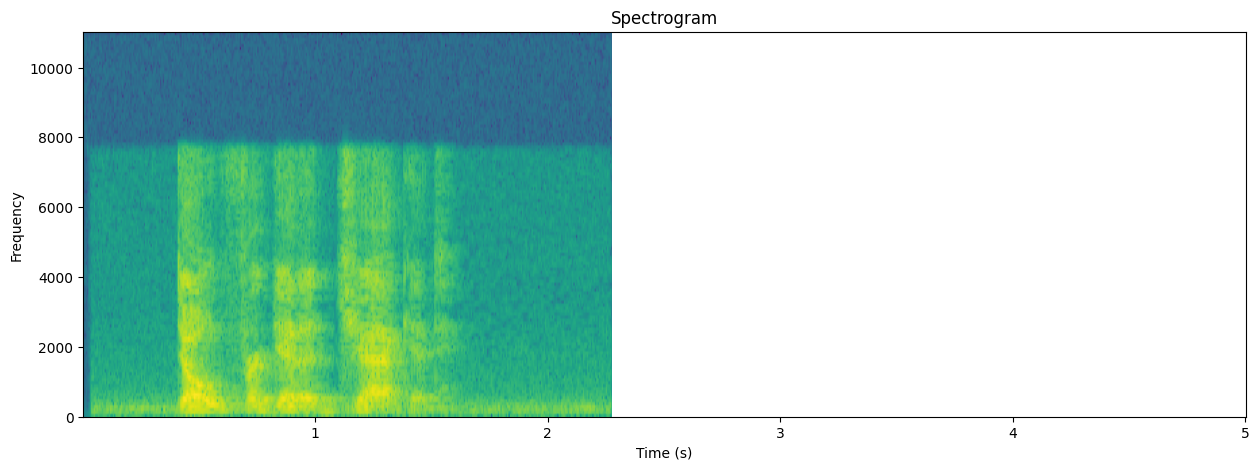

In [51]:
plotSpectrogram(files[0], audioTime)

#### Audio Spectrogram in Mel Scale

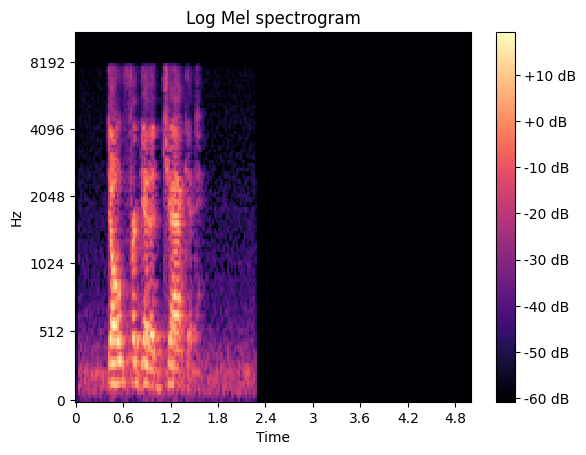

In [52]:
plotMelSpectogram(files[0], 1024, 512, 128)

## Feature Extraction

- We will create two feature spaces from the audio.
  - We can work on time domain, or we can work in frequency domain. There are multiple of features that can help improving the model:
    - Zero crossing rate: The rate of sign-changes of the signal during the duration of a particular frame.
    - Energy: The sum of squares of the signal values, normalized by the respective frame length.
    - Extras:
      - Pitch: The fundamental frequency of the signal.
  - Convert the audio waveform to mel spectrogram and use this as the feature space.

In [4]:
def extractFeatures(data, labels, n_fft, hopSize, n_mels):
    output = np.empty((len(data), 4), dtype=np.ndarray)
    
    for i, audioFile in enumerate(data):
        # Calculate the zero crossing rate
        zeroCrossingRate = calculateZeroCrossingRate(audioFile, n_fft, hopSize)
        # Calculate the energy
        energy = calculateEnergy(audioFile, n_fft, hopSize)
        # Calculate the Mel Spectrogram
        melSpectrogram = calculateMelSpectogram(audioFile, n_fft, hopSize, n_mels)
        # Append the features to the output array
        output[i][0] = zeroCrossingRate
        output[i][1] = energy
        output[i][2] = melSpectrogram
        output[i][3] = labels[i]
        output[i][0] = output[i][0].reshape(1, output[i][0].shape[0])
        output[i][1] = output[i][1].reshape(1, output[i][1].shape[0])
    return output

def getFeatures(files, labels, n_fft, hop_size, n_mels, noise = False, time_shift = False, change_speed = False, pitch_shift = False, volume_scale = False):
    savingDirectory = "processed/n_fft_" + str(n_fft) + "_hop_size_" + str(hop_size) + "_n_mels_" + str(n_mels)
    if noise:
        savingDirectory += "_noise"
    if time_shift:
        savingDirectory += "_timeShift"
    if change_speed:
        savingDirectory += "_changeSpeed"
    if pitch_shift:
        savingDirectory += "_pitchShift"
    if volume_scale:
        savingDirectory += "_volumeScale"
    if not os.path.exists(savingDirectory):
        
        x_train_val, x_test, y_train_val, y_test = train_test_split(files, labels, train_size=0.7, random_state=42, stratify=labels)
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, train_size=0.95, random_state=42, stratify=y_train_val)
        
        # Now let's augment the training data 
        augmentedData, augmentedLabel = augmentData(x_train, y_train, f"augmented/n_fft_{n_fft}_hop_size_{hop_size}_n_mels_{n_mels}", noise, time_shift, change_speed, pitch_shift, volume_scale)
        x_train = augmentedData
        y_train = augmentedLabel

        # Extract the features
        x_train = extractFeatures(x_train, y_train, n_fft, hop_size, n_mels)
        x_val = extractFeatures(x_val, y_val, n_fft, hop_size, n_mels)
        x_test = extractFeatures(x_test, y_test, n_fft, hop_size, n_mels)
        
        os.makedirs(savingDirectory)
        np.save(savingDirectory + "/x_train.npy", x_train)
        np.save(savingDirectory + "/x_val.npy", x_val)
        np.save(savingDirectory + "/x_test.npy", x_test)
        np.save(savingDirectory + "/y_train.npy", y_train)
        np.save(savingDirectory + "/y_val.npy", y_val)
        np.save(savingDirectory + "/y_test.npy", y_test)
    else:
        
        x_train = np.load(savingDirectory + "/x_train.npy", allow_pickle=True)
        x_val = np.load(savingDirectory + "/x_val.npy", allow_pickle=True)
        x_test = np.load(savingDirectory + "/x_test.npy", allow_pickle=True)
        y_train = np.load(savingDirectory + "/y_train.npy", allow_pickle=True)
        y_val = np.load(savingDirectory + "/y_val.npy", allow_pickle=True)
        y_test = np.load(savingDirectory + "/y_test.npy", allow_pickle=True)
    return x_train, x_val, x_test, y_train, y_val, y_test

## Splitting the Dataset

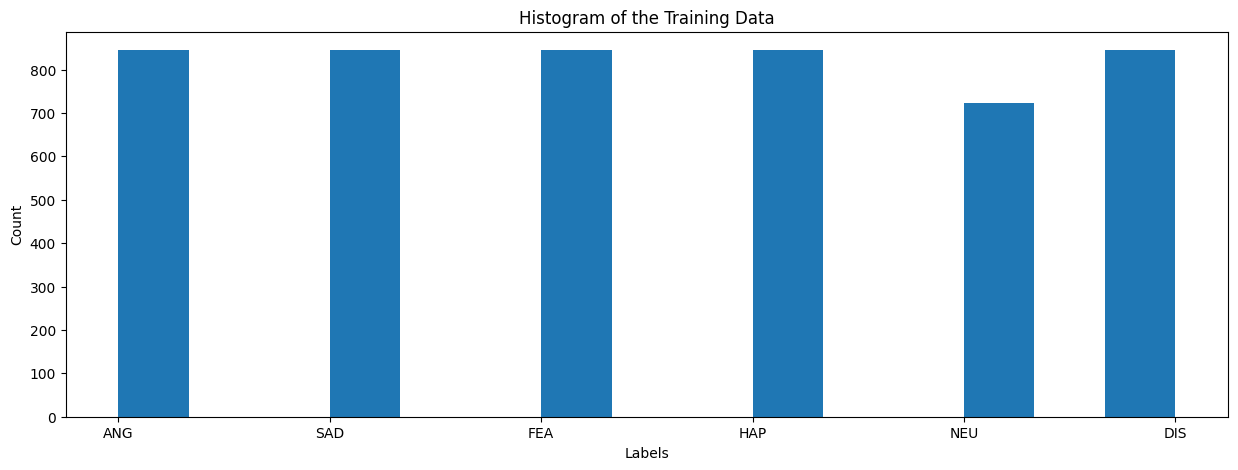

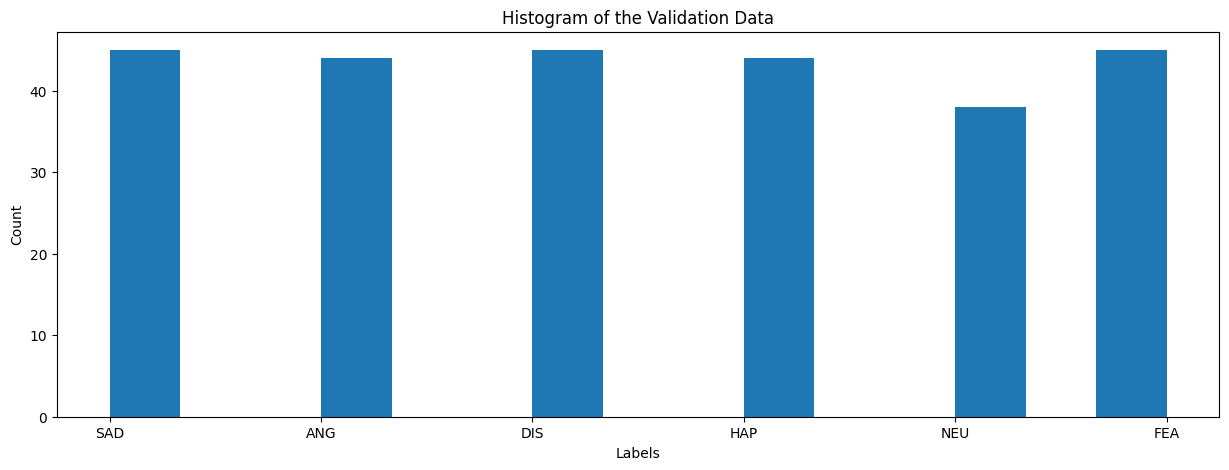

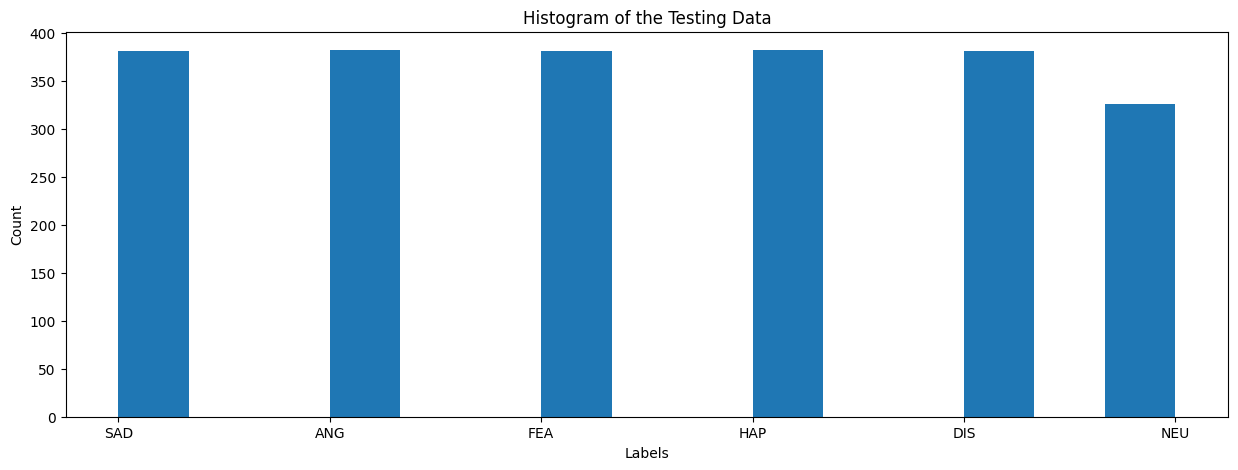

In [54]:
x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files, labels, N_FFT, HOP_SIZE, N_MELS)
# Plotting the histogram of the training data
plotHistogram(y_train, 'Training Data')
# Plotting the histogram of the validation data
plotHistogram(y_val, 'Validation Data')
# Plotting the histogram of the testing data
plotHistogram(y_test, 'Testing Data')

- We have the choice of either undersampling or oversampling the dataset. We will not be using either of them as they are not very effective in this case since the differences in number of samples is not big. We will be using the entire dataset as it is.

## Building The models

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch, gc
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The acceleration is on: ", device)
gc.collect()
torch.cuda.empty_cache()

The acceleration is on:  cuda


### Dataset Class

In [6]:
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.zcr = torch.tensor([data[i][0] for i in range(len(data))], dtype=torch.float32)
        self.energy = torch.tensor([data[i][1] for i in range(len(data))], dtype=torch.float32)
        self.melSpectogram = torch.tensor([data[i][2] for i in range(len(data))], dtype=torch.float32)
        
        indexLabels = [labelToIndex[labels[i]] for i in range(len(labels))]
        oneHotLabels = np.zeros((len(labels), len(stringLabels)))
        oneHotLabels[np.arange(len(labels)), indexLabels] = 1
        self.labels = torch.tensor(oneHotLabels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.zcr)
    
    def __getitem__(self, idx):
        return self.zcr[idx], self.energy[idx], self.melSpectogram[idx], self.labels[idx]

### DummyNet 1D

- For DummyNet 1D, we will be using the processed data with the following parameters:
  - N_MELS = 40
  - N_FFT = 480
  - HOP_SIZE = 160

#### Model Architecture

In [34]:
# Let's create a model with the following architecture:
# Conv1d layer with 512 filters, kernel size of 5, stride of 1, and relu activation
# MaxPool1d layer with kernel size of 5 and stride of 2
# Conv1d layer with 512 filters, kernel size of 5, stride of 1, and relu activation
# MaxPool1d layer with kernel size of 5 and stride of 2
# conv1d layer with 128 filters, kernel size of 5, stride of 1, and relu activation
# MaxPool1d layer with kernel size of 5 and stride of 2
# Flatten layer
# fully connected layer with 256 neurons and relu activation
# fully connected layer with 6 neurons and softmax activation
class DummyNet1d(nn.Module):
    
    def __init__(self, input_shape, useZCR = False, useEnergy = False, useMelSpectogram = False):
        super(DummyNet1d, self).__init__()
        self.useZCR = useZCR
        self.useEnergy = useEnergy
        self.useMelSpectogram = useMelSpectogram
        currentInputShape = input_shape
        self.conv1 = nn.Conv1d(1, 512, kernel_size=5, stride=1)
        currentInputShape = int((currentInputShape - 5) / 1 + 1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        currentInputShape = int((currentInputShape - 5) / 2 + 1)
        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, stride=1)
        currentInputShape = int((currentInputShape - 5) / 1 + 1)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2)
        currentInputShape = int((currentInputShape - 5) / 2 + 1)
        self.conv3 = nn.Conv1d(512, 128, kernel_size=5, stride=1)
        currentInputShape = int((currentInputShape - 5) / 1 + 1)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2)
        currentInputShape = int((currentInputShape - 5) / 2 + 1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(currentInputShape * 128, 256)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
    
    def trainEpochs(self, criterion, optimizer, train_loader, val_loader, num_epochs = 10):
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for i, data in enumerate(train_loader):
                zcr, energy, melSpectogram, labels = data
                zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)

                inputs = self.checkInputs(zcr, energy, melSpectogram)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * melSpectogram.size(0)
                
            self.eval()
            for i, data in enumerate(val_loader):
                zcr, energy, melSpectogram, labels = data
                zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
                inputs = self.checkInputs(zcr, energy, melSpectogram)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * melSpectogram.size(0)
                
            train_loss = train_loss / len(train_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch+1, train_loss, val_loss))
        return train_losses, val_losses

    def checkInputs(self, zcr, energy, melSpectogram):
        if(self.useZCR and self.useEnergy):
            inputs = torch.cat((zcr, energy), dim=2)
        elif(self.useZCR):
            inputs = zcr
        elif(self.useEnergy):
            inputs = energy
        elif(self.useMelSpectogram):
            # flatten the last two shapes of the melSpectogram
            inputs = melSpectogram.view(BATCH_SIZE, 1,-1)
        return inputs

    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)
    
    def test(self, test_loader):
        self.eval()
        accuracy = 0
        for i, data in enumerate(test_loader):
            zcr, energy, melSpectogram, labels = data
            zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
            inputs = self.checkInputs(zcr, energy, melSpectogram)
            output = self.predict(inputs)
            label = torch.argmax(labels, dim=1)
            accuracy += torch.sum(output == label)
        accuracy = accuracy / len(test_loader.dataset)
        print("Accuracy: {:.2f}%".format(accuracy*100))

    def analyze(self, test_loader):
        self.eval()
        output = []
        label = []
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output.append(self.predict(melSpectogram))
            label.append(torch.argmax(labels, dim=1))
        output = torch.cat(output)
        label = torch.cat(label)
        print(classification_report(label.cpu(), output.cpu(), target_names=stringLabels))
        ConfusionMatrixDisplay(confusion_matrix(label.cpu(), output.cpu()), display_labels=stringLabels).plot()
        plt.show()

#### Using only Zero Crossing Rate

In [44]:
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.0001
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hopSize = HOP_SIZE, n_mels= N_MELS, noise = True, timeShift = True, changeSpeed = True, pitchShift = True, volumeScale = True)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][0].shape[1], useZCR=True, useEnergy=False, useMelSpectogram=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = EPOCHS)
model.test(test_dataloader)

Epoch: 1 	Training Loss: 1.778701 	Validation Loss: 1.707505
Epoch: 2 	Training Loss: 1.715757 	Validation Loss: 1.679098
Epoch: 3 	Training Loss: 1.687507 	Validation Loss: 1.663394
Epoch: 4 	Training Loss: 1.675399 	Validation Loss: 1.664896
Epoch: 5 	Training Loss: 1.666912 	Validation Loss: 1.645057
Epoch: 6 	Training Loss: 1.664126 	Validation Loss: 1.645664
Epoch: 7 	Training Loss: 1.659585 	Validation Loss: 1.657760
Epoch: 8 	Training Loss: 1.656048 	Validation Loss: 1.641443
Epoch: 9 	Training Loss: 1.646030 	Validation Loss: 1.646745
Epoch: 10 	Training Loss: 1.643694 	Validation Loss: 1.637301
Epoch: 11 	Training Loss: 1.639238 	Validation Loss: 1.636946
Epoch: 12 	Training Loss: 1.636827 	Validation Loss: 1.636816
Epoch: 13 	Training Loss: 1.633323 	Validation Loss: 1.643311
Epoch: 14 	Training Loss: 1.634355 	Validation Loss: 1.661415
Epoch: 15 	Training Loss: 1.626599 	Validation Loss: 1.639856
Epoch: 16 	Training Loss: 1.625837 	Validation Loss: 1.637831
Epoch: 17 	Traini

In [ ]:
model.analyze(test_dataloader)

#### Using only Energy

In [45]:
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.0001
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hopSize = HOP_SIZE, n_mels= N_MELS, noise = True, timeShift = True, changeSpeed = True, pitchShift = True, volumeScale = True)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][1].shape[1], useZCR=False, useEnergy=True, useMelSpectogram=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = EPOCHS)
model.test(test_dataloader)

Epoch: 1 	Training Loss: 1.753306 	Validation Loss: 1.720331
Epoch: 2 	Training Loss: 1.690250 	Validation Loss: 1.690617
Epoch: 3 	Training Loss: 1.665306 	Validation Loss: 1.665814
Epoch: 4 	Training Loss: 1.650927 	Validation Loss: 1.646003
Epoch: 5 	Training Loss: 1.643172 	Validation Loss: 1.655262
Epoch: 6 	Training Loss: 1.641419 	Validation Loss: 1.644180
Epoch: 7 	Training Loss: 1.635355 	Validation Loss: 1.641310
Epoch: 8 	Training Loss: 1.636812 	Validation Loss: 1.618085
Epoch: 9 	Training Loss: 1.631929 	Validation Loss: 1.635113
Epoch: 10 	Training Loss: 1.628821 	Validation Loss: 1.648462
Epoch: 11 	Training Loss: 1.627680 	Validation Loss: 1.646686
Epoch: 12 	Training Loss: 1.625890 	Validation Loss: 1.635439
Epoch: 13 	Training Loss: 1.624817 	Validation Loss: 1.652445
Epoch: 14 	Training Loss: 1.624457 	Validation Loss: 1.648735
Epoch: 15 	Training Loss: 1.623222 	Validation Loss: 1.648608
Epoch: 16 	Training Loss: 1.621561 	Validation Loss: 1.645706
Epoch: 17 	Traini

In [ ]:
model.analyze(test_dataloader)

#### Using both Zero Crossing Rate and Energy

In [46]:
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.0001
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hopSize = HOP_SIZE, n_mels= N_MELS, noise = True, timeShift = True, changeSpeed = True, pitchShift = True, volumeScale = True)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][1].shape[1] + x_train[0][0].shape[1], useZCR=True, useEnergy=True, useMelSpectogram=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = EPOCHS)
model.test(test_dataloader)

Epoch: 1 	Training Loss: 1.751610 	Validation Loss: 1.698720
Epoch: 2 	Training Loss: 1.687283 	Validation Loss: 1.675198
Epoch: 3 	Training Loss: 1.666633 	Validation Loss: 1.652641
Epoch: 4 	Training Loss: 1.640799 	Validation Loss: 1.628825
Epoch: 5 	Training Loss: 1.630906 	Validation Loss: 1.618004
Epoch: 6 	Training Loss: 1.620619 	Validation Loss: 1.619392
Epoch: 7 	Training Loss: 1.614513 	Validation Loss: 1.598807
Epoch: 8 	Training Loss: 1.610934 	Validation Loss: 1.595194
Epoch: 9 	Training Loss: 1.608500 	Validation Loss: 1.583061
Epoch: 10 	Training Loss: 1.604237 	Validation Loss: 1.610182
Epoch: 11 	Training Loss: 1.598021 	Validation Loss: 1.589842
Epoch: 12 	Training Loss: 1.597124 	Validation Loss: 1.578055
Epoch: 13 	Training Loss: 1.595179 	Validation Loss: 1.581042
Epoch: 14 	Training Loss: 1.592813 	Validation Loss: 1.577248
Epoch: 15 	Training Loss: 1.589732 	Validation Loss: 1.574242
Epoch: 16 	Training Loss: 1.588374 	Validation Loss: 1.576427
Epoch: 17 	Traini

In [ ]:
model.analyze(test_dataloader)

#### Using Mel Spectrogram

In [32]:
BATCH_SIZE = 1
EPOCHS = 5
LEARNING_RATE = 0.001
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hopSize = HOP_SIZE, n_mels= N_MELS, noise = True, timeShift = True, changeSpeed = True, pitchShift = True, volumeScale = True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][2].shape[0]* x_train[0][2].shape[1], useZCR=False, useEnergy=False, useMelSpectogram=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = EPOCHS)
model.test(test_dataloader)

Epoch: 1 	Training Loss: 1.683592 	Validation Loss: 1.609120
Epoch: 2 	Training Loss: 1.595552 	Validation Loss: 1.582922
Epoch: 3 	Training Loss: 1.568909 	Validation Loss: 1.592995
Epoch: 4 	Training Loss: 1.545439 	Validation Loss: 1.589089
Epoch: 5 	Training Loss: 1.528274 	Validation Loss: 1.593878
Accuracy: 48.41%


In [ ]:
model.analyze(test_dataloader)

#### Results

- From the previous results, it is clear that the model is so naive and simple that it can't learn anything meaningful from the data. We can tell that from the rate of training loss since that it is decreasing so slow. 
- The Zero Crossing Rate is not the best feature to use in this case since it is not very informative. The Energy feature is better than the Zero Crossing Rate, but it is still not enough. However, combining both of them together is better than using each of them alone.
- The Mel Spectrogram is the best feature to use in this case since it is the most informative one. It is better than using both Zero Crossing Rate and Energy together.

### RezoNet 2D

#### Model Architecture

In [19]:
class RezoNet2d(nn.Module):
    
    def __init__(self, input_shape):
        super(RezoNet2d, self).__init__()
        self.flatten = nn.Flatten()
        currentInputShape = input_shape # this is two dimensional
        # Create a 2d convolutional layer with 10 layers, kernel size of (9,1)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (1,9))
        currentInputShape[0] = currentInputShape[0] + 0 -1 +1
        currentInputShape[1] = currentInputShape[1] + 0 - 9 + 1

        # Create a 2d convolutional layer with 10 layers, kernel size of (5,1), padding is same
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,5))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 5 + 1

        # Create a 2d convolutional layer with 10 layers, kernel size of (3,1), padding is same
        self.conv3 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,3))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 3 + 1

        # Create a pooling layer of kernel size(3,1)
        self.pool1 = nn.MaxPool2d(kernel_size = (1,3), stride = (1,1))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 3 + 1
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(10)

        
        # Create a 2D convolutional layer with 40 layers, kernel size of (3,1), padding is same
        self.conv4 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (1,3))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 3 + 1

        # Create a 2D convolutional layer with 40 layers, kernel size of (3,1), padding is same
        self.conv5 = nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = (1,3))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 3 + 1

        # Create a pooling layer of kernel size(2,1)
        self.pool2 = nn.MaxPool2d(kernel_size = (1,2))
        currentInputShape[0] = currentInputShape[0] // 1
        currentInputShape[1] = currentInputShape[1] // 2
        # Batch Normalization
        self.bn2 = nn.BatchNorm2d(20)
        

        # Create a 2D convolutional layer with 80 layers, kernel size of (10,1), no padding
        self.conv6 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (1,13))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 13 + 1


        # Create a 2D convolutional layer with 80 layers, kernel size of (1,1), no padding
        self.conv7 = nn.Conv2d(in_channels = 40, out_channels = 40, kernel_size = (1,1))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 1 + 1

        # Create a pooling layer of kernel size(2,1)
        self.pool3 = nn.MaxPool2d(kernel_size = (1,2))
        currentInputShape[0] = currentInputShape[0] // 1
        currentInputShape[1] = currentInputShape[1] // 2

        # Batch Normalization
        self.bn3 = nn.BatchNorm2d(40)

        # Create a 2D convolutional layer with 80 filters, kernel size of (1,1)
        self.conv8 = nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = (1,1))
        currentInputShape[0] = currentInputShape[0] + 0 - 1 + 1
        currentInputShape[1] = currentInputShape[1] + 0 - 1 + 1

        flattened = currentInputShape[0] * currentInputShape[1] * 80
        # The output of model is fed into a fully connected layer with 80 neurons
        self.fc1 = nn.Linear(flattened, 80)
        self.fc2 = nn.Linear(80, 30)
        self.softmax = nn.Linear(30, 6)

    def forward(self, x):
        # relu activation function for all convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # max pooling layer
        x = self.pool1(x)
        # batch normalization
        x = self.bn1(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        # max pooling layer
        x = self.pool2(x)
        # batch normalization
        x = self.bn2(x)

        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        # max pooling layer
        x = self.pool3(x)
        # batch normalization
        x = self.bn3(x)

        x = F.relu(self.conv8(x))
        # flatten the output of the last convolutional layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(self.softmax(x), dim = 1)
        return x
    
    def trainEpochs(self, criterion, optimizer, train_loader, val_loader, num_epochs = 10, lr_decay = False, lr_decay_epoch = 5, lr_decay_factor = 0.1):
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for i, data in enumerate(train_loader):
                _, _, melSpectogram, labels = data
                melSpectogram, labels =  melSpectogram.to(device), labels.to(device)
                # unsqueeze the melSpectogram to add a channel dimension
                melSpectogram = melSpectogram.unsqueeze(1)
                optimizer.zero_grad()
                outputs = self(melSpectogram)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * melSpectogram.size(0)
            
            with torch.no_grad():
                self.eval()
                for i, data in enumerate(val_loader):
                    _, _, melSpectogram, labels = data
                    melSpectogram, labels = melSpectogram.to(device), labels.to(device)
                    melSpectogram = melSpectogram.unsqueeze(1)
                    outputs = self(melSpectogram)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * melSpectogram.size(0)
                
            train_loss = train_loss / len(train_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch+1, train_loss, val_loss))
            if lr_decay and (epoch+1) % lr_decay_epoch == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor
        return train_losses, val_losses

    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)
    
    def test(self, test_loader):
        self.eval()
        accuracy = 0
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output = self.predict(melSpectogram)
            label = torch.argmax(labels, dim=1)
            accuracy += torch.sum(output == label)
        accuracy = accuracy / len(test_loader.dataset)
        print("Accuracy: {:.2f}%".format(accuracy*100))
    
    def analyze(self, test_loader):
        self.eval()
        output = []
        label = []
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output.append(self.predict(melSpectogram))
            label.append(torch.argmax(labels, dim=1))
        output = torch.cat(output)
        label = torch.cat(label)
        print(classification_report(label.cpu(), output.cpu(), target_names=stringLabels))
        ConfusionMatrixDisplay(confusion_matrix(label.cpu(), output.cpu()), display_labels=stringLabels).plot()
        plt.show()

#### Running the Model

In [8]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
noise = True
time_shift = True
change_speed = True
pitch_shift = True
volume_scale = True


x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = noise, time_shift = time_shift, change_speed = change_speed, pitch_shift = pitch_shift, volume_scale = volume_scale)
print("Extracted Features for the Data Successfully!")
print("Number of Training Examples: ", len(x_train))
print("Number of Validation Examples: ", len(x_val))
print("Number of Testing Examples: ", len(x_test))

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Extracted Features for the Data Successfully!
Number of Training Examples:  29688
Number of Validation Examples:  261
Number of Testing Examples:  2233


C:\Users\Yousef\AppData\Local\Temp\ipykernel_16860\645635343.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  self.zcr = torch.tensor([data[i][0] for i in range(len(data))], dtype=torch.float32)


In [16]:
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.00001
LR_DECAY = True
LR_DECAY_EPOCH = 30
LR_DECAY_FACTOR = 0.5
WEIGHT_DECAY = 0.0001 # L2 regularization

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Created DataLoaders Successfully!")

model = RezoNet2d([x_train[0][2].shape[0], x_train[0][2].shape[1]]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)
model.trainEpochs(criterion, optimizer, train_dataloader, val_dataloader, num_epochs=EPOCHS, lr_decay=LR_DECAY, lr_decay_epoch=LR_DECAY_EPOCH, lr_decay_factor=LR_DECAY_FACTOR)
model.test(train_dataloader)
model.test(val_dataloader)
model.test(test_dataloader)
modelParams = f"models/ExpoNet_BATCHSIZE{BATCH_SIZE}_LR_{LEARNING_RATE}_Nfft{N_FFT}_hopsize_{HOP_SIZE}_nmels_{N_MELS}_epochs_{EPOCHS}_lr_decay_{LR_DECAY}_lr_decay_epoch_{LR_DECAY_EPOCH}_lr_decay_factor_{LR_DECAY_FACTOR}_weight_decay_{WEIGHT_DECAY}.pth"
torch.save(model.state_dict(), modelParams)

Created DataLoaders Successfully!
Epoch: 1 	Training Loss: 1.625930 	Validation Loss: 1.591417
Epoch: 2 	Training Loss: 1.538678 	Validation Loss: 1.566872
Epoch: 3 	Training Loss: 1.488794 	Validation Loss: 1.555593
Epoch: 4 	Training Loss: 1.452315 	Validation Loss: 1.549378
Epoch: 5 	Training Loss: 1.418391 	Validation Loss: 1.545334
Epoch: 6 	Training Loss: 1.389108 	Validation Loss: 1.550712
Epoch: 7 	Training Loss: 1.364705 	Validation Loss: 1.545866
Epoch: 8 	Training Loss: 1.339860 	Validation Loss: 1.543028
Epoch: 9 	Training Loss: 1.318225 	Validation Loss: 1.546631
Epoch: 10 	Training Loss: 1.298045 	Validation Loss: 1.554028
Epoch: 11 	Training Loss: 1.278448 	Validation Loss: 1.562158
Epoch: 12 	Training Loss: 1.260359 	Validation Loss: 1.579288
Epoch: 13 	Training Loss: 1.244887 	Validation Loss: 1.550995
Epoch: 14 	Training Loss: 1.229168 	Validation Loss: 1.555039
Epoch: 15 	Training Loss: 1.216275 	Validation Loss: 1.561170
Epoch: 16 	Training Loss: 1.203032 	Validatio

In [ ]:
model.analyze(test_dataloader)